#  Отчет по лабораторной работе № 2 *"Методы классификации данных"*
##  *ФИО студента:  Чедлеев Владимир Викторович*
##  *Группа: 16 В-1*
##  *Вариант №2*

## Изучение набора данных.
    Набор данных состоит из 101 животного из зоопарка. Для описания животных существует 16 переменных с различными признаками. 7 типов классов: млекопитающее, птица, рептилия, рыба, амфибия, насекомые и беспозвоночные (Mammal, Bird, Reptile, Fish, Amphibian, Bug and Invertebrate). Цель этого набора данных - предсказать классификацию животных на основе переменных.
    Информация об атрибутах (имя атрибута и значение домена):
   ### zoo.csv
   * **animal_name** *уникально для каждого экземпляра*
   * **hair (волосы)** *Boolean*
   * **eggs (яйца)** *Boolean*
   * **milk (молоко)** *Boolean*
   * **airborne (летающий)** *Boolean*
   * **aquatic (водный)** *Boolean*
   * **predator (хищник)** *Boolean*
   * **toothed (имеет зубы)** *Boolean*
   * **backbone (позвоночный)** *Boolean*
   * **breathes (дышащий)** *Boolean*
   * **venomous (ядовитый)** *Boolean*
   * **fins (имеет ребра)** *Boolean*
   * **legs (ноги)** *Numeric (числовые). Набор значений: {0,2,4,5,6,8}*
   * **tail (хвост)** *Boolean*
   * **domestic (домашнее)** *Boolean*
   * **catsize (семейство кошачьих)** *Boolean*
   * **class_type (тип класса)** *Numeric (числовые). Целочисленные значения в диапазоне [1,7]*
   
   ### class.csv
   
   
   * **Class_Number (номер класса)** *Numeric (числовые). Целочисленные значения в диапазоне [1,7]*
   * **Number_Of_Animal_Species_In_Class (количество видов животных в классе)** *Numeric (числовые)*
   * **Class_Type character (тип класса)** *Фактическое описание типа класса*
   * **Animal_Names character (название класса животных)** *Список животных, попадающих в категорию класса*
   
    
    

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_blobs
from sklearn.model_selection import StratifiedKFold
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import label_binarize
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.cross_decomposition import CCA
from sklearn.datasets import make_multilabel_classification
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.metrics import average_precision_score
%matplotlib inline

In [ ]:
data = pd.read_csv("C:\\Users\\User\\Desktop\\LearnMachin\\ml_2018\\lb2\\Chedleev\\zoo.csv")  #  Создание объекта набора данных
dfClass = pd.read_csv("C:\\Users\\User\\Desktop\\LearnMachin\\ml_2018\\lb2\\Chedleev\\class.csv")  #  Создание объекта классов

In [ ]:
data.head(99)

In [ ]:
dfClass.head(7)

## Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции.

In [26]:
print(f"Размер набора данных до удаления: {data.count().max()}")
if data.count().max()==data.drop_duplicates(keep='first').count().max():
    print("Дубликатов нет")
else:
    data.drop_duplicates(keep='first', inplace = True)  #  Удаление дубликатов, кроме первого вхождения; удаление в данной таблице
    print(f"Размер набора данных до удаления: {data.count().max()}")
data.shape

Размер набора данных до удаления: 101
Дубликатов нет


(101, 18)

## Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая).

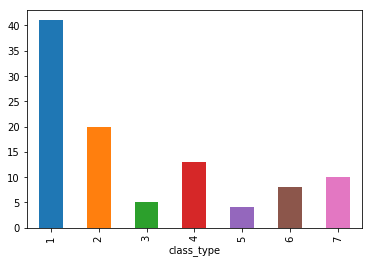

In [27]:
data.groupby(["class_type"])["class_type"].count().plot(kind='bar') #  Гистограмма данных по классам.
#  По гистограмме видно, что больше всего животных относится к 1 классу. Остальные классы мало отличаются друг от друга по количеству.

    По гистограмме видно, что дисбаланс классов выражен не сильно
***PR-кривая*** *(кривая точности полноты)*
   
*Для построения необходимо:*
1. Отсортировать объекты по возрастанию их оценки принадлежности первому классу.
2. Рассматриваем пороги классификации начиная с максимального.
3. Для каждого порога находим точность и полноту соответсвующего алгоритма.
4. Отмечаем соответсвующую точку в осях "полнота-точность".
5. Соединив точки, получаем Precision-Recall-кривую.
   
*Свойства PR-кривой:*
1. Левая точка: всегда (0,0) (все объекты относим к классу 0).
2. Правая точка зависит от данных. Полнота всегда равна 1, а точность равна отношению числа объектов первого класса выборки к общему размеру выборки.
3. Если выборка идеально разделима, то кривая пройдет через точку (1,1).
4. Чем больше площадь под кривой, тем лучше алгоритм.

> PR кривая хорошо подходит для измерения качества при сильном дисбалансе классов.
Максимальная площадь под PR-кривой зависит от выборки.

***ROC-кривая*** *(reciever operating characteristic)*

    По оси X: FPR (false positive rate - доля ошибочных положительных классификаций). FPR называется специфичность алгоритма.
    По оси Y: TPR (true positive rate - доля правильных положительных классификаций). TPR называется чувствительностью алгоритма.
*Свойства ROC-кривой:*
1. Левая точка: всегда (0,0) (все объекты относим к классу 0).
2. Правая точка: всегда (1,1) (все объекты относим к классу 1).
3. Если выборка идеально разделима, то кривая пройдет через точку (0,1).
4. Площадь меняется от 1/2 до 1.
5. Чем больше площадь под кривой, тем лучше алгоритм.

> Метрики классов нормируются на размеры классов, ROC-кривая не изменится при перемене соотношения классов. Интерпретация: AUC-ROC равен вероятности того, что случайно взятый объект класса 1 получит оценку выше, чем случайно взятый объект класса 0. Недостаток: проблемы при сильном дисбалансе классов.

> ***Исходя из вышеуказанных характеристик будем использовать ROC-кривую.***

## Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию).

> По заданию необходимо использовать ***классификатор K ближайших соседей (задаётся количество ближайших объектов)*** и ***линейный классификатор (персептрон)***
    
    Многие алгоритмы машинного обучения чувствительны к масштабированию данных. К таким алгоритмам, например, относится метод ближайших соседей, машина опорных векторов и др. В этом случае количественные признаки полезно нормализовать. Это можно делать разными способами. Например, каждый количественный признак приведем к нулевому среднему и единичному среднеквадратичному отклонению.

In [28]:
data.describe()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.425743,0.198020,0.584158,0.405941,0.237624,0.356436,0.554455,0.603960,0.821782,0.792079,0.079208,0.168317,2.841584,0.742574,0.128713,0.435644,2.831683
std,0.496921,0.400495,0.495325,0.493522,0.427750,0.481335,0.499505,0.491512,0.384605,0.407844,0.271410,0.376013,2.033385,0.439397,0.336552,0.498314,2.102709
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,2.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,7.000000


### Выделение числовых и категориаьных признаков:

In [29]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print (f"Категоиальные признаки: {categorical_columns}")
print (f"Числовые признаки: {numerical_columns}")

Категоиальные признаки: ['animal_name']
Числовые признаки: ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 'catsize', 'class_type']


In [30]:
data[categorical_columns].describe()  #  Получение информации по категориальным признакам
# count - общее число заполненных ячеек
# unique -  количество значений, которые принимает данный признак
# top - самое популярное (часто встречающееся) значение этого признака
# freq - количество объектов, в которых встречается самое частое значение данного признака

,animal_name
count,101
unique,100
top,frog
freq,2


,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
hair,1.000000,-0.427851,-0.817382,0.878503,-0.198431,-0.473554,-0.154769,0.492531,0.191681,0.441149,-0.104245,-0.280313,0.394009,0.048973,0.207208,0.455020,-0.562384
feathers,-0.427851,1.000000,0.419248,-0.410761,0.656553,-0.058552,-0.104430,-0.613631,0.231403,0.254588,-0.145739,-0.223541,-0.206686,0.292569,0.031586,-0.135934,-0.197520
eggs,-0.817382,0.419248,1.000000,-0.938848,0.376646,0.376244,0.011605,-0.642150,-0.340420,-0.382777,0.098689,0.164796,-0.224918,-0.221090,-0.155610,-0.514650,0.661825
milk,0.878503,-0.410761,-0.938848,1.000000,-0.366765,-0.362613,-0.029721,0.628168,0.384958,0.423527,-0.242449,-0.156328,0.214196,0.210026,0.163928,0.574906,-0.723683
airborne,-0.198431,0.656553,0.376646,-0.366765,1.000000,-0.172638,-0.295181,-0.594311,-0.104718,0.286039,0.008528,-0.251157,0.043712,0.009482,0.063274,-0.349768,0.022677
aquatic,-0.473554,-0.058552,0.376244,-0.362613,-0.172638,1.000000,0.375978,0.053150,0.022463,-0.637506,0.087915,0.604492,-0.360638,-0.034642,-0.224308,-0.111866,0.326639
predator,-0.154769,-0.104430,0.011605,-0.029721,-0.295181,0.375978,1.000000,0.129452,0.051022,-0.262931,0.115391,0.190302,-0.099723,0.018947,-0.309794,0.144790,0.061179
toothed,0.492531,-0.613631,-0.642150,0.628168,-0.594311,0.053150,0.129452,1.000000,0.575085,-0.065690,-0.062344,0.364292,-0.193476,0.310368,0.069430,0.344010,-0.471527
backbone,0.191681,0.231403,-0.340420,0.384958,-0.104718,0.022463,0.051022,0.575085,1.000000,0.207666,-0.246611,0.209499,-0.432856,0.731762,0.101733,0.356976,-0.828845
breathes,0.441149,0.254588,-0.382777,0.423527,0.286039,-0.637506,-0.262931,-0.065690,0.207666,1.000000,-0.120752,-0.617219,0.369868,0.088952,0.124068,0.204125,-0.519308


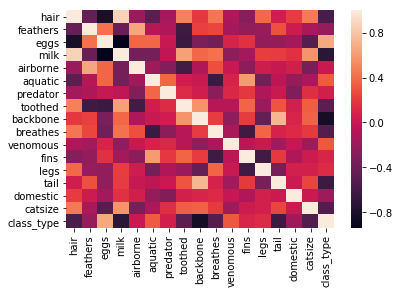

In [31]:
sns.heatmap(data.corr())
data.corr()

> Библиотека scikit-learn не умеет напрямую обрабатывать категориальные признаки. Поэтому прежде чем подавать данные на вход алгоритмов машинного обучения преобразуем категориальные признаки в количественные

In [32]:
data['animal_name'].unique()

array(['aardvark', 'antelope', 'bass', 'bear', 'boar', 'buffalo', 'calf',
       'carp', 'catfish', 'cavy', 'cheetah', 'chicken', 'chub', 'clam',
       'crab', 'crayfish', 'crow', 'deer', 'dogfish', 'dolphin', 'dove',
       'duck', 'elephant', 'flamingo', 'flea', 'frog', 'fruitbat',
       'giraffe', 'girl', 'gnat', 'goat', 'gorilla', 'gull', 'haddock',
       'hamster', 'hare', 'hawk', 'herring', 'honeybee', 'housefly',
       'kiwi', 'ladybird', 'lark', 'leopard', 'lion', 'lobster', 'lynx',
       'mink', 'mole', 'mongoose', 'moth', 'newt', 'octopus', 'opossum',
       'oryx', 'ostrich', 'parakeet', 'penguin', 'pheasant', 'pike',
       'piranha', 'pitviper', 'platypus', 'polecat', 'pony', 'porpoise',
       'puma', 'pussycat', 'raccoon', 'reindeer', 'rhea', 'scorpion',
       'seahorse', 'seal', 'sealion', 'seasnake', 'seawasp', 'skimmer',
       'skua', 'slowworm', 'slug', 'sole', 'sparrow', 'squirrel',
       'starfish', 'stingray', 'swan', 'termite', 'toad', 'tortoise',
       

### Диаграмма BoxPlot для признаков до масштабирования

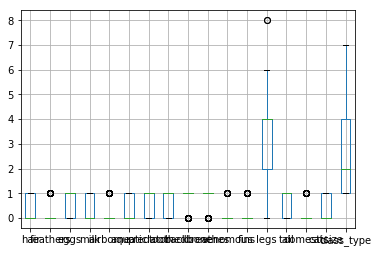

In [33]:
data.boxplot()

> Нормализуем количественные признаки. Каждый количественный признак приведем к нулевому среднему и единичному среднеквадратичному отклонению

In [34]:
data_numerical = data[['hair', 'feathers', 'eggs', 'milk', 'airborne',
       'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous',
       'fins', 'legs', 'tail', 'domestic', 'catsize', 'class_type']]  #  Количественные признаки
data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()  #  Приведение к нулевому среднему и единичному среднеквадратичному отклонению
data_numerical.describe()  #  Информация по таблице

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
count,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02,1.010000e+02
mean,1.670831e-16,-2.198461e-17,9.893076e-17,-1.253123e-16,1.099231e-16,4.616769e-17,-8.354153e-17,5.716000e-17,4.836615e-17,-2.638154e-17,1.791746e-16,-5.716000e-17,7.145000e-17,1.363046e-16,1.802738e-16,-1.538923e-17,6.595384e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.567607e-01,-4.944380e-01,-1.179344e+00,-8.225373e-01,-5.555198e-01,-7.405150e-01,-1.110010e+00,-1.228780e+00,-2.136693e+00,-1.942114e+00,-2.918387e-01,-4.476351e-01,-1.397465e+00,-1.689987e+00,-3.824456e-01,-8.742351e-01,-8.711063e-01
25%,-8.567607e-01,-4.944380e-01,-1.179344e+00,-8.225373e-01,-5.555198e-01,-7.405150e-01,-1.110010e+00,-1.228780e+00,4.633792e-01,5.098049e-01,-2.918387e-01,-4.476351e-01,-4.138834e-01,-1.689987e+00,-3.824456e-01,-8.742351e-01,-8.711063e-01
50%,-8.567607e-01,-4.944380e-01,8.395333e-01,-8.225373e-01,-5.555198e-01,-7.405150e-01,8.919727e-01,8.057576e-01,4.633792e-01,5.098049e-01,-2.918387e-01,-4.476351e-01,5.696983e-01,5.858620e-01,-3.824456e-01,-8.742351e-01,-3.955293e-01
75%,1.155631e+00,-4.944380e-01,8.395333e-01,1.203713e+00,-5.555198e-01,1.337041e+00,8.919727e-01,8.057576e-01,4.633792e-01,5.098049e-01,-2.918387e-01,-4.476351e-01,5.696983e-01,5.858620e-01,-3.824456e-01,1.132532e+00,5.556245e-01
max,1.155631e+00,2.002474e+00,8.395333e-01,1.203713e+00,1.782293e+00,1.337041e+00,8.919727e-01,8.057576e-01,4.633792e-01,5.098049e-01,3.392624e+00,2.211844e+00,2.536862e+00,5.858620e-01,2.588862e+00,1.132532e+00,1.982355e+00


### Диаграмма BoxPlot для признаков после масштабирования

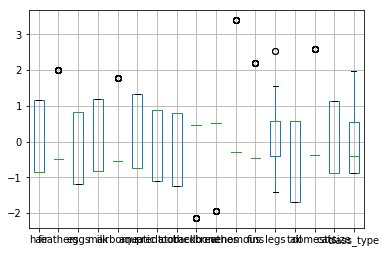

In [35]:
data_numerical.boxplot()

In [36]:
dataNew = pd.concat((data["animal_name"], data_numerical), axis=1)  #  Соединение масштабированных числовых признаков с категориальными
print(dataNew.shape)
dataNew.head()

(101, 18)


,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1.155631,-0.494438,-1.179344,1.203713,-0.55552,-0.740515,0.891973,0.805758,0.463379,0.509805,-0.291839,-0.447635,0.569698,-1.689987,-0.382446,1.132532,-0.871106
1,antelope,1.155631,-0.494438,-1.179344,1.203713,-0.55552,-0.740515,-1.110010,0.805758,0.463379,0.509805,-0.291839,-0.447635,0.569698,0.585862,-0.382446,1.132532,-0.871106
2,bass,-0.856761,-0.494438,0.839533,-0.822537,-0.55552,1.337041,0.891973,0.805758,0.463379,-1.942114,-0.291839,2.211844,-1.397465,0.585862,-0.382446,-0.874235,0.555625
3,bear,1.155631,-0.494438,-1.179344,1.203713,-0.55552,-0.740515,0.891973,0.805758,0.463379,0.509805,-0.291839,-0.447635,0.569698,-1.689987,-0.382446,1.132532,-0.871106
4,boar,1.155631,-0.494438,-1.179344,1.203713,-0.55552,-0.740515,0.891973,0.805758,0.463379,0.509805,-0.291839,-0.447635,0.569698,0.585862,-0.382446,1.132532,-0.871106


> Для удобства отдельно рассмотрим столбцы, соответствующие входным признакам (это будет матрица X), а отдельно – выделенный признак (вектор y)

In [37]:
X = dataNew.drop(('animal_name'), axis=1)  # Выбрасываем столбец 'animal_name'
#Y = dataNew['animal_name']  #  Столбец 'animal_name'
Y = data.class_type
feature_names = X.columns
print (feature_names)
print(f"Входных признаков: {X.shape[1]}")

Index(['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator',
       'toothed', 'backbone', 'breathes', 'venomous', 'fins', 'legs', 'tail',
       'domestic', 'catsize', 'class_type'],
      dtype='object')
Входных признаков: 17


In [38]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)  #  Разобьем данные на обучающую/тестовую выборки в отношении 70%:30%
N_train, _ = x_train.shape 
N_test,  _ = x_test.shape 
print (N_train, N_test)
#x_train, y_train – обучающая выборка, x_test, y_test – тестовая выборка

70 31


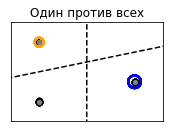

<Figure size 1440x1440 with 0 Axes>

In [39]:
def plot_hyperplane(clf, min_x, max_x, linestyle, label):
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(min_x - 5, max_x + 5)  # make sure the line is long enough
    yy = a * xx - (clf.intercept_[0]) / w[1]
    plt.plot(xx, yy, linestyle, label=label)
Y = label_binarize(Y, classes=[1, 2, 3])
X = CCA(n_components=2).fit(X, Y).transform(X)
min_x = np.min(X[:, 0])
max_x = np.max(X[:, 0])

min_y = np.min(X[:, 1])
max_y = np.max(X[:, 1])
classif = OneVsRestClassifier(SVC(kernel='linear'))
classif.fit(X, Y)
plt.subplot(2, 2, 1)
plt.title("Один против всех")

zero_class = np.where(Y[:, 0])
one_class = np.where(Y[:, 1])
plt.scatter(X[:, 0], X[:, 1], s=40, c='gray', edgecolors=(0, 0, 0))
plt.scatter(X[zero_class, 0], X[zero_class, 1], s=160, edgecolors='b',
            facecolors='none', linewidths=2, label='Class 1')
plt.scatter(X[one_class, 0], X[one_class, 1], s=80, edgecolors='orange',
            facecolors='none', linewidths=2, label='Class 2')

plot_hyperplane(classif.estimators_[0], min_x, max_x, 'k--',
            'Boundary\nfor class 1')
plot_hyperplane(classif.estimators_[1], min_x, max_x, 'k--',
            'Boundary\nfor class 2')
plt.xticks(())
plt.yticks(())

plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)

plt.figure(figsize=(20, 20))
plt.show()

### Метод K ближайших соседей (задаётся количество ближайших объектов)
> Для нового объекта алгоритм ищет в обучающей выборке k наиболее близких объекта и относит новый объект к тому классу, которому принадлежит большинство из них. Количество соседей k соответствует параметру n_neighbors. По умолчанию, n_neighbors = 5

***Обучение модели***

In [40]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

> После того, как модель обучена, мы можем предсказывать значение целевого признака по входным признакам для новых объектов. Делается это с помощью метода predict

In [41]:
y_train_predict = knn.predict(x_train)
y_test_predict = knn.predict(x_test)
err_train = np.mean(y_train != y_train_predict)
err_test  = np.mean(y_test  != y_test_predict)
print (f"Ошибки на обучающей выборке: {err_train}\nОшибки на тестовой выборке: {err_test}")

Ошибки на обучающей выборке: 0.02857142857142857
Ошибки на тестовой выборке: 0.03225806451612903


### Линейный классификатор (персептрон)

In [42]:
X = dataNew.drop(('animal_name'), axis=1)  # Выбрасываем столбец 'animal_name'
#Y = dataNew['animal_name']  #  Столбец 'animal_name'
Y = data.class_type
#  Обучение - контроль
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 7)

In [43]:
#  Обучение модели и предсказание
classifier = LogisticRegression()
classifier.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [44]:
y_train_predict = classifier.predict(x_train)
y_test_predict = classifier.predict(x_test)
err_train = np.mean(y_train != y_train_predict)
err_test  = np.mean(y_test  != y_test_predict)
print (f"Ошибки на обучающей выборке: {err_train}\nОшибки на тестовой выборке: {err_test}")
print (f"Score: {classifier.score(x_train, y_train)}")

Ошибки на обучающей выборке: 0.0
Ошибки на тестовой выборке: 0.0
Score: 1.0


> ROC - кривая

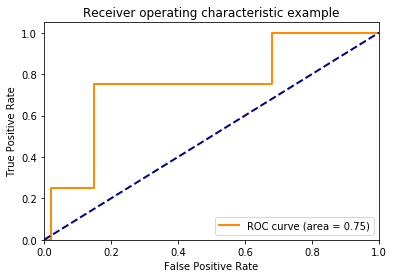

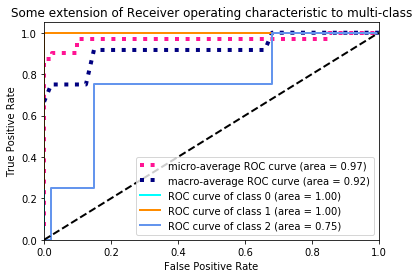

In [45]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import (auc, roc_curve, precision_recall_curve, average_precision_score)
Y = label_binarize(Y, classes=[1, 2, 3])
n_classes = Y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.5,
                                                    random_state=0)
y_score = classif.fit(X_train, y_train).decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

> PR - кривая

Average precision score, micro-averaged over all classes: 0.98


Text(0.5,1,'Average precision score, micro-averaged over all classes: AP=0.98')

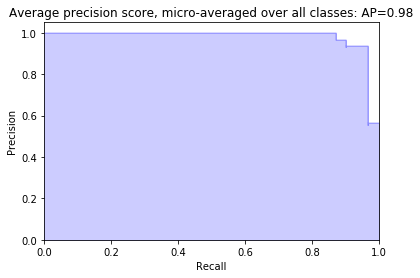

In [47]:
n_classes = Y.shape[1]
random_state = np.random.RandomState(0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5,
                                                    random_state=random_state)

# We use OneVsRestClassifier for multi-label prediction
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils.fixes import signature
from sklearn.metrics import (auc, roc_curve, precision_recall_curve, average_precision_score)
# Run classifier
classifier = OneVsRestClassifier(svm.LinearSVC(random_state=random_state))
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
                 **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))